# NucSegAI Result Analysis - Cell Type Quantification

This notebook analyzes NucSegAI JSON output files to extract:
- Cell counts by type
- Cell type proportions
- Type probability statistics

This notebook provides:
1. ✅ Single JSON file analysis
2. ✅ Cell type counts and proportions
3. ✅ Type probability statistics (min, median, mean, max, standard deviation)
4. ✅ Visualizations (bar charts, pie charts)
5. ✅ CSV export functionality
6. ✅ Batch processing for all json files

---

## Step 1: Import Required Libraries

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## Step 2: Define Cell Type Dictionary

This mapping translates numeric cell type IDs to human-readable names.

In [2]:
# Cell type mapping
CELL_TYPE_DICT = {
    0: "Undefined",
    1: "Epithelium (PD-L1lo/Ki67lo)",
    2: "Epithelium (PD-L1hi/Ki67hi)",
    3: "Macrophage",
    4: "Lymphocyte",
    5: "Vascular",
    6: "Fibroblast/Stroma"
}

# Color mapping for visualization (converted from RGB to hex)
CELL_TYPE_COLORS = {
    0: "#000000",  # Black (RGB: 0, 0, 0) - Undefined
    1: "#387F39",  # Dark Green (RGB: 56, 127, 57) - Epithelium low
    2: "#00FF00",  # Bright Green (RGB: 0, 255, 0) - Epithelium high
    3: "#FC8D62",  # Coral/Salmon (RGB: 252, 141, 98) - Macrophage
    4: "#FFD92F",  # Yellow (RGB: 255, 217, 47) - Lymphocyte
    5: "#4535C1",  # Blue/Purple (RGB: 69, 53, 193) - Vascular
    6: "#17BECF"   # Cyan (RGB: 23, 190, 207) - Fibroblast/Stroma
}

print("Cell Type Mapping:")
for type_id, type_name in CELL_TYPE_DICT.items():
    print(f"  {type_id}: {type_name} -> {CELL_TYPE_COLORS[type_id]}")

Cell Type Mapping:
  0: Undefined -> #000000
  1: Epithelium (PD-L1lo/Ki67lo) -> #387F39
  2: Epithelium (PD-L1hi/Ki67hi) -> #00FF00
  3: Macrophage -> #FC8D62
  4: Lymphocyte -> #FFD92F
  5: Vascular -> #4535C1
  6: Fibroblast/Stroma -> #17BECF


## Step 3: Define Function to Analyze Single JSON File

This function reads a single JSON file and extracts all relevant statistics.

In [3]:
def analyze_single_json(json_path):
    """
    Analyze a single NucSegAI JSON output file.
    
    Parameters:
    -----------
    json_path : str or Path
        Path to the JSON file
    
    Returns:
    --------
    dict : Dictionary containing analysis results
    """
    # Read JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Extract nucleus data
    nuclei = data.get('nuc', {})
    
    if not nuclei:
        return {
            'filename': Path(json_path).name,
            'total_cells': 0,
            'cell_counts': {},
            'cell_proportions': {},
            'type_prob_stats': {}
        }
    
    # Initialize storage
    cell_types = []
    type_probs = []
    type_probs_by_type = defaultdict(list)
    
    # Extract data from each nucleus
    for nucleus_id, nucleus_data in nuclei.items():
        cell_type = nucleus_data.get('type',        0)
        type_prob = nucleus_data.get('type_prob',   0)
        
        cell_types.append(cell_type)
        type_probs.append(type_prob)
        type_probs_by_type[cell_type].append(type_prob)
    
    # Count cells by type
    cell_counts = Counter(cell_types)
    total_cells = len(cell_types)
    
    # Calculate proportions
    cell_proportions = {}
    for cell_type, count in cell_counts.items():
        cell_proportions[cell_type] = count / total_cells
    
    # Calculate type probability statistics (overall)
    type_prob_stats_overall = {
        'min':      np.min(type_probs) if type_probs else 0,
        'median':   np.median(type_probs) if type_probs else 0,
        'mean':     np.mean(type_probs) if type_probs else 0,
        'max':      np.max(type_probs) if type_probs else 0,
        'std':      np.std(type_probs) if type_probs else 0
    }
    
    # Calculate type probability statistics by cell type
    type_prob_stats_by_type = {}
    for cell_type, probs in type_probs_by_type.items():
        type_prob_stats_by_type[cell_type] = {
            'min':      np.min(probs),
            'median':   np.median(probs),
            'mean':     np.mean(probs),
            'max':      np.max(probs),
            'std':      np.std(probs)
        }
    
    return {
        'filename': Path(json_path).name,
        'total_cells': total_cells,
        'cell_counts': dict(cell_counts),
        'cell_proportions': cell_proportions,
        'type_prob_stats_overall': type_prob_stats_overall,
        'type_prob_stats_by_type': type_prob_stats_by_type
    }

print("✅ Function defined: analyze_single_json()")

✅ Function defined: analyze_single_json()


## Step 4: Display Results Function

Create a function to display results in a readable format.

In [4]:
def display_results(results):
    """
    Display analysis results in a formatted way.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    print("="*80)
    print(f"Analysis Results for: {results['filename']}")
    print("="*80)
    print(f"\n📊 Total Cells Detected: {results['total_cells']:,}\n")
    
    # Cell Counts and Proportions
    print("─" * 80)
    print("Cell Type Distribution")
    print("─" * 80)
    print(f"{'Cell Type':<35} {'Count':>12} {'Proportion':>12} {'Percentage':>10}")
    print("─" * 80)
    
    for cell_type in sorted(results['cell_counts'].keys()):
        count = results['cell_counts'][cell_type]
        proportion = results['cell_proportions'][cell_type]
        percentage = proportion * 100
        type_name = CELL_TYPE_DICT.get(cell_type, f"Unknown ({cell_type})")
        print(f"{type_name:<35} {count:>12,} {proportion:>12.4f} {percentage:>9.2f}%")
    
    # Overall Type Probability Statistics
    print("\n" + "─" * 80)
    print("Overall Type Probability Statistics")
    print("─" * 80)
    stats = results['type_prob_stats_overall']
    print(f"  Minimum:  {stats['min']:.10f}")
    print(f"  Median:   {stats['median']:.10f}")
    print(f"  Mean:     {stats['mean']:.10f}")
    print(f"  Maximum:  {stats['max']:.10f}")
    print(f"  Std Dev:  {stats['std']:.10f}")
    
    # Type Probability Statistics by Cell Type
    print("\n" + "─" * 80)
    print("Type Probability Statistics by Cell Type")
    print("─" * 80)
    
    for cell_type in sorted(results['type_prob_stats_by_type'].keys()):
        type_name = CELL_TYPE_DICT.get(cell_type, f"Unknown ({cell_type})")
        stats = results['type_prob_stats_by_type'][cell_type]
        print(f"\n{type_name}:")
        print(f"  Min: {stats['min']:.6f} | Med: {stats['median']:.6f} | Mean: {stats['mean']:.6f} | Max: {stats['max']:.6f} | Std: {stats['std']:.6f}")
    
    print("\n" + "="*80)

print("✅ Function defined: display_results()")

✅ Function defined: display_results()


## Step 5: Visualization Functions

In [5]:
def plot_cell_type_distribution(results):
    """
    Create visualizations for cell type distribution.
    
    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Prepare data
    cell_types = sorted(results['cell_counts'].keys())
    cell_names = [CELL_TYPE_DICT.get(ct, f"Type {ct}") for ct in cell_types]
    counts = [results['cell_counts'][ct] for ct in cell_types]
    colors = [CELL_TYPE_COLORS.get(ct, "#808080") for ct in cell_types]
    
    # Bar plot
    bars = axes[0].bar(range(len(cell_types)), counts, color=colors, edgecolor='black', linewidth=1.5)
    axes[0].set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Cell Counts by Type\n{results["filename"]}', fontsize=14, fontweight='bold')
    axes[0].set_xticks(range(len(cell_types)))

    # Right-align labels with bars - labels end at bar center
    axes[0].set_xticklabels(cell_names, rotation=45, ha='right', rotation_mode='anchor')
    axes[0].grid(axis='y', alpha=0.3)

    # Add count labels on bars
    for i, count in enumerate(counts):
        axes[0].text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold')

    # Pie chart with autopct for percentages only on larger slices
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 3 else ''  # Only show percentage if > 3%

    # Create pie chart with legend instead of labels for small slices
    wedges, texts, autotexts = axes[1].pie(
        counts,
        labels=None,  # Don't add labels directly to avoid overlap
        colors=colors,
        autopct=autopct_format,
        startangle=90,
        textprops={'fontsize': 10, 'weight': 'bold'},
        pctdistance=0.85
    )

    # Create legend with labels and percentages
    legend_labels = [f'{name}: {count:,} ({count/sum(counts)*100:.1f}%)'
                     for name, count in zip(cell_names, counts)]
    axes[1].legend(
        wedges,
        legend_labels,
        title="Cell Types",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        fontsize=9
    )

    axes[1].set_title(f'Cell Type Proportions\n{results["filename"]}', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

def plot_type_probability_distribution(results):
    """
    Create bar plot for type probabilities by cell type.

    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json()
    """
    fig, ax = plt.subplots(figsize=(14, 6))

    cell_types = sorted(results['type_prob_stats_by_type'].keys())
    cell_names = [CELL_TYPE_DICT.get(ct, f"Type {ct}") for ct in cell_types]

    # Create bar plot for mean values with error bars
    means = [results['type_prob_stats_by_type'][ct]['mean'] for ct in cell_types]
    stds = [results['type_prob_stats_by_type'][ct]['std'] for ct in cell_types]
    colors_list = [CELL_TYPE_COLORS.get(ct, "#808080") for ct in cell_types]

    bars = ax.bar(range(len(cell_types)), means, yerr=stds, color=colors_list,
                   edgecolor='black', linewidth=1.5, capsize=5, alpha=0.8)

    ax.set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Type Probability', fontsize=12, fontweight='bold')
    ax.set_title(f'Type Probability by Cell Type (Mean ± Std Dev)\n{results["filename"]}',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(cell_types)))

    # Right-align labels with bars - labels end at bar center
    ax.set_xticklabels(cell_names, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_ylim(0, 1.05)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (mean, std) in enumerate(zip(means, stds)):
        ax.text(i, mean + std + 0.02, f'{mean:.3f}', ha='center', va='bottom', 
                fontweight='bold', fontsize=9)
    
    plt.tight_layout()
    plt.show()

print("✅ Visualization functions defined")

✅ Visualization functions defined


## Step 6: Apply Confidence Threshold Filter and Analyze Single JSON File

**👉 Update the path below to point to your JSON file**

In [7]:
"""
Refactored Cell Type Batch Analysis
Consolidates Steps 6, 7, and 9 with reduced duplication
"""

from pathlib import Path
from collections import Counter
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple, Union
import pandas as pd
import matplotlib.pyplot as plt
import json

# ==================== Configuration ====================
@dataclass
class AnalysisConfig:
    """Central configuration for analysis parameters"""
    pie_chart_min_percent: float = 3.0
    figure_size: Tuple[int, int] = (16, 12)
    progress_interval: int = 10
    default_threshold: float = 0.5

CONFIG = AnalysisConfig()

# ==================== Data Models ====================
@dataclass
class AnalysisResult:
    """Unified result container for both single and aggregated analyses"""
    total_files: int = 1
    total_cells: int = 0
    cell_counts: Dict = field(default_factory=dict)
    cell_proportions: Dict = field(default_factory=dict)

    # Optional fields for filtered results
    is_filtered: bool = False
    threshold: Optional[float] = None
    original_counts: Dict = field(default_factory=dict)
    reclassified_count: int = 0

    def calculate_proportions(self):
        """Calculate proportions from counts"""
        if self.total_cells > 0:
            self.cell_proportions = {
                cell_type: count / self.total_cells
                for cell_type, count in self.cell_counts.items()
            }

    def get_percentage(self, cell_type: str) -> float:
        """Get percentage for a cell type"""
        return self.cell_proportions.get(cell_type, 0) * 100

# ==================== Core Analysis Functions ====================
class CellTypeAnalyzer:
    """Main analyzer class to reduce duplication"""

    def __init__(self, cell_type_dict: Dict, cell_type_colors: Dict):
        self.cell_type_dict = cell_type_dict
        self.cell_type_colors = cell_type_colors

    def process_json_file(self, json_path: Path, threshold: Optional[float] = None) -> AnalysisResult:
        """
        Process a single JSON file with optional filtering.
        Combines functionality of analyze_single_json and apply_confidence_filter.
        """
        with open(json_path, 'r') as f:
            data = json.load(f)

        result = AnalysisResult(
            total_cells=len(data),
            is_filtered=(threshold is not None),
            threshold=threshold
        )

        if threshold is None:
            # Unfiltered analysis
            result.cell_counts = Counter(cell['type'] for cell in data)
        else:
            # Filtered analysis with confidence threshold
            original_counts = Counter()
            filtered_counts = Counter()
            reclassified = 0

            for cell in data:
                original_type = cell['type']
                original_counts[original_type] += 1

                if cell.get('confidence', 1.0) < threshold:
                    # Reclassify based on secondary predictions
                    new_type = self._get_secondary_type(cell, threshold)
                    if new_type != original_type:
                        reclassified += 1
                    filtered_counts[new_type] += 1
                else:
                    filtered_counts[original_type] += 1

            result.cell_counts = dict(filtered_counts)
            result.original_counts = dict(original_counts)
            result.reclassified_count = reclassified

        result.calculate_proportions()
        return result

    def _get_secondary_type(self, cell: Dict, threshold: float) -> int:
        """Get secondary cell type if confidence is below threshold"""
        # Implement your logic for secondary type selection
        # This is a placeholder - adapt to your actual logic
        secondary = cell.get('secondary_predictions', [])
        for pred in secondary:
            if pred.get('confidence', 0) >= threshold:
                return pred['type']
        return cell['type']  # Default to original if no suitable secondary

    def process_directory(self, directory: Path, threshold: Optional[float] = None) -> List[AnalysisResult]:
        """Process all JSON files in a directory"""
        json_files = sorted(directory.glob("*.json"))

        if not json_files:
            print(f"❌ No JSON files found in {directory}")
            return []

        filter_status = f" (threshold={threshold})" if threshold else " (unfiltered)"
        print(f"Found {len(json_files)} JSON files{filter_status}")
        print("Processing...")

        results = []
        for i, json_file in enumerate(json_files, 1):
            if i % CONFIG.progress_interval == 0:
                print(f"Processed {i}/{len(json_files)} files...")
            results.append(self.process_json_file(json_file, threshold))

        print(f"✅ Completed! Processed {len(json_files)} files.")
        return results

    def aggregate_results(self, results: List[AnalysisResult]) -> AnalysisResult:
        """Aggregate multiple results into one"""
        if not results:
            return AnalysisResult()

        aggregated = AnalysisResult(
            total_files=len(results),
            total_cells=sum(r.total_cells for r in results),
            is_filtered=results[0].is_filtered,
            threshold=results[0].threshold
        )

        # Aggregate counts
        counts = Counter()
        original = Counter()

        for r in results:
            counts.update(r.cell_counts)
            if r.is_filtered:
                original.update(r.original_counts)

        aggregated.cell_counts = dict(counts)
        if aggregated.is_filtered:
            aggregated.original_counts = dict(original)
            aggregated.reclassified_count = sum(r.reclassified_count for r in results)

        aggregated.calculate_proportions()
        return aggregated

# ==================== Display and Export ====================
class ResultsDisplay:
    """Unified display and visualization class"""

    def __init__(self, analyzer: CellTypeAnalyzer):
        self.analyzer = analyzer

    def display_results(self, result: AnalysisResult, title_prefix: str = ""):
        """Generic display function for any result"""
        title = f"{title_prefix}{'FILTERED' if result.is_filtered else 'UNFILTERED'} RESULTS"
        print(f"\n{'='*80}\n{title}")

        if result.is_filtered and result.threshold:
            print(f"Threshold: {result.threshold}")

        print(f"{'='*80}")
        print(f"Total Files: {result.total_files}")
        print(f"Total Cells: {result.total_cells:,}")

        if result.is_filtered and result.reclassified_count:
            pct = result.reclassified_count / result.total_cells * 100
            print(f"Total Reclassified: {result.reclassified_count:,} ({pct:.2f}%)")

        self._display_table(result)

    def _display_table(self, result: AnalysisResult):
        """Display results table"""
        print(f"\n{'─'*80}")

        if result.is_filtered:
            headers = f"{'Cell Type':<35} {'Original':>12} {'Filtered':>12} {'Change':>12} {'Percentage':>12}"
        else:
            headers = f"{'Cell Type':<35} {'Count':>12} {'Proportion':>12} {'Percentage':>12}"

        print(headers)
        print('─'*80)

        for cell_type in sorted(result.cell_counts.keys()):
            name = self.analyzer.cell_type_dict.get(cell_type, f"Type {cell_type}")
            count = result.cell_counts[cell_type]
            percentage = result.get_percentage(cell_type)

            if result.is_filtered:
                original = result.original_counts.get(cell_type, 0)
                change = count - original
                change_str = f"+{change:,}" if change >= 0 else f"{change:,}"
                print(f"{name:<35} {original:>12,} {count:>12,} {change_str:>12} {percentage:>11.2f}%")
            else:
                proportion = result.cell_proportions[cell_type]
                print(f"{name:<35} {count:>12,} {proportion:>12.4f} {percentage:>11.2f}%")

        print('='*80)

    def create_comparison_plot(self, unfiltered: AnalysisResult, filtered: AnalysisResult):
        """Create unified comparison visualization"""
        fig, axes = plt.subplots(2, 2, figsize=CONFIG.figure_size)

        # Prepare data
        all_types = set(unfiltered.cell_counts.keys()) | set(filtered.cell_counts.keys())
        cell_types = sorted(all_types)
        names = [self.analyzer.cell_type_dict.get(ct, f"Type {ct}") for ct in cell_types]
        colors = [self.analyzer.cell_type_colors.get(ct, "#808080") for ct in cell_types]

        unfiltered_counts = [unfiltered.cell_counts.get(ct, 0) for ct in cell_types]
        filtered_counts = [filtered.cell_counts.get(ct, 0) for ct in cell_types]

        # Create visualizations
        self._create_bar_chart(axes[0, 0], names, colors, unfiltered_counts,
                              f'Unfiltered ({unfiltered.total_cells:,} cells)')
        self._create_bar_chart(axes[0, 1], names, colors, filtered_counts,
                              f'Filtered (threshold={filtered.threshold}, {filtered.reclassified_count:,} reclassified)')
        self._create_pie_chart(axes[1, 0], names, colors, unfiltered_counts,
                              'Unfiltered Proportions')
        self._create_pie_chart(axes[1, 1], names, colors, filtered_counts,
                              'Filtered Proportions')

        plt.tight_layout()
        plt.show()

    def _create_bar_chart(self, ax, names, colors, counts, subtitle):
        """Generic bar chart creation"""
        ax.bar(range(len(names)), counts, color=colors, edgecolor='black', linewidth=1.5)
        ax.set_xlabel('Cell Type', fontsize=12, fontweight='bold')
        ax.set_ylabel('Count', fontsize=12, fontweight='bold')
        ax.set_title(f'Cell Counts\n{subtitle}', fontsize=14, fontweight='bold')
        ax.set_xticks(range(len(names)))
        ax.set_xticklabels(names, rotation=45, ha='right')
        ax.grid(axis='y', alpha=0.3)

        for i, count in enumerate(counts):
            ax.text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)

    def _create_pie_chart(self, ax, names, colors, counts, title):
        """Generic pie chart creation"""
        def autopct_format(pct):
            return f'{pct:.1f}%' if pct > CONFIG.pie_chart_min_percent else ''

        wedges, _, _ = ax.pie(counts, labels=None, colors=colors,
                              autopct=autopct_format, startangle=90,
                              textprops={'fontsize': 10, 'weight': 'bold'},
                              pctdistance=0.85)

        legend_labels = [f'{name}: {count:,}' for name, count in zip(names, counts)]
        ax.legend(wedges, legend_labels, title="Cell Types", loc="center left",
                 bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)
        ax.set_title(title, fontsize=14, fontweight='bold')

    def export_to_csv(self, result: AnalysisResult, output_path: str) -> pd.DataFrame:
        """Export results to CSV"""
        rows = []

        for cell_type in sorted(result.cell_counts.keys()):
            row = {
                'Total_Files': result.total_files,
                'Total_Cells': result.total_cells,
                'Cell_Type_ID': cell_type,
                'Cell_Type_Name': self.analyzer.cell_type_dict.get(cell_type, f"Type {cell_type}"),
                'Count': result.cell_counts[cell_type],
                'Proportion': result.cell_proportions[cell_type],
                'Percentage': result.get_percentage(cell_type)
            }

            if result.is_filtered:
                row.update({
                    'Original_Count': result.original_counts.get(cell_type, 0),
                    'Count_Change': result.cell_counts[cell_type] - result.original_counts.get(cell_type, 0),
                    'Total_Reclassified': result.reclassified_count,
                    'Threshold': result.threshold
                })

            rows.append(row)

        df = pd.DataFrame(rows)
        df.to_csv(output_path, index=False)
        print(f"✅ Results exported to: {output_path}")
        return df

# ==================== Main Pipeline ====================
class BatchAnalysisPipeline:
    """Main pipeline orchestrator"""

    def __init__(self, cell_type_dict: Dict, cell_type_colors: Dict):
        self.analyzer = CellTypeAnalyzer(cell_type_dict, cell_type_colors)
        self.display = ResultsDisplay(self.analyzer)

    def run_single_file_analysis(self, json_path: Union[str, Path],
                                 threshold: Optional[float] = None,
                                 compare: bool = True) -> Tuple[AnalysisResult, Optional[AnalysisResult]]:
        """Analyze a single JSON file with optional filtering and comparison"""
        json_path = Path(json_path)

        # Unfiltered analysis
        unfiltered = self.analyzer.process_json_file(json_path)
        self.display.display_results(unfiltered, "SINGLE FILE ")

        filtered = None
        if threshold is not None:
            # Filtered analysis
            filtered = self.analyzer.process_json_file(json_path, threshold)
            self.display.display_results(filtered, "SINGLE FILE ")

            if compare:
                self.display.create_comparison_plot(unfiltered, filtered)

        return unfiltered, filtered

    def run_batch_analysis(self, directory: Union[str, Path],
                          threshold: float = CONFIG.default_threshold) -> Tuple[AnalysisResult, AnalysisResult]:
        """Run complete batch analysis pipeline"""
        directory = Path(directory)

        print("="*80)
        print("BATCH ANALYSIS - Processing All JSON Files")
        print("="*80)

        # Step 1: Unfiltered analysis
        print("\n📊 Step 1: Analyzing unfiltered results...")
        unfiltered_results = self.analyzer.process_directory(directory)
        aggregated_unfiltered = self.analyzer.aggregate_results(unfiltered_results)
        self.display.display_results(aggregated_unfiltered, "AGGREGATED ")

        # Step 2: Filtered analysis
        print(f"\n📊 Step 2: Analyzing filtered results (threshold={threshold})...")
        filtered_results = self.analyzer.process_directory(directory, threshold)
        aggregated_filtered = self.analyzer.aggregate_results(filtered_results)
        self.display.display_results(aggregated_filtered, "AGGREGATED ")

        # Step 3: Visualizations
        print("\n📊 Step 3: Generating comparison visualizations...")
        self.display.create_comparison_plot(aggregated_unfiltered, aggregated_filtered)

        # Step 4: Export
        print("\n📊 Step 4: Exporting results to CSV...")
        self.display.export_to_csv(aggregated_unfiltered, "aggregated_results_unfiltered.csv")
        threshold_str = str(int(threshold * 100))
        self.display.export_to_csv(aggregated_filtered, f"aggregated_results_filtered_{threshold_str}.csv")

        # Summary
        self._print_summary(aggregated_unfiltered, aggregated_filtered, threshold_str)

        return aggregated_unfiltered, aggregated_filtered

    def _print_summary(self, unfiltered: AnalysisResult, filtered: AnalysisResult, threshold_str: str):
        """Print analysis summary"""
        print("\n" + "="*80)
        print("BATCH ANALYSIS COMPLETE")
        print("="*80)
        print(f"✅ Processed {unfiltered.total_files} JSON files")
        print(f"✅ Total cells analyzed: {unfiltered.total_cells:,}")
        print(f"✅ Cells reclassified: {filtered.reclassified_count:,}")
        print("\n📁 Output files:")
        print("   - aggregated_results_unfiltered.csv")
        print(f"   - aggregated_results_filtered_{threshold_str}.csv")
        print("\n✅ Analysis complete!")

# ==================== Usage Example ====================
if __name__ == "__main__":
    # Define your cell type mappings
    CELL_TYPE_DICT = {
        0: "Type 0 - Description",
        1: "Type 1 - Description",
        # Add your mappings
    }

    CELL_TYPE_COLORS = {
        0: "#FF0000",
        1: "#00FF00",
        # Add your colors
    }

    # Initialize pipeline
    pipeline = BatchAnalysisPipeline(CELL_TYPE_DICT, CELL_TYPE_COLORS)

    # For single file analysis (Steps 6 & 7)
    json_file = "/mnt/g/GDC-TCGA-LUAD/00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/pred_00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/json/tile_39520_17784.json"
    unfiltered, filtered = pipeline.run_single_file_analysis(
        json_file,
        threshold=0.5,  # Optional: set to None for unfiltered only
        compare=True
    )

    # For batch analysis (Step 9)
    json_directory = "/mnt/g/GDC-TCGA-LUAD/00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/pred_00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/json"
    aggregated_unfiltered, aggregated_filtered = pipeline.run_batch_analysis(
        json_directory,
        threshold=0.5
    )

FileNotFoundError: [Errno 2] No such file or directory: 'path/to/single/file.json'

## Step 7: Apply Confidence Threshold Filter

In [7]:
"""
## Step 7: Apply Confidence Threshold Filter

Filter out low-confidence predictions and reclassify them as "Undefined".
"""

def apply_confidence_filter(json_path, threshold=0.5):
    """
    Apply confidence threshold filter to reclassify low-confidence predictions.

    Parameters:
    -----------
    json_path : str or Path
        Path to the JSON file
    threshold : float
        Minimum type probability threshold (default: 0.5)

    Returns:
    --------
    dict : Filtered analysis results
    """
    # Read JSON file
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Extract nucleus data
    nuclei = data.get('nuc', {})

    if not nuclei:
        return {
            'filename': Path(json_path).name,
            'threshold': threshold,
            'total_cells': 0,
            'reclassified_count': 0,
            'cell_counts': {},
            'cell_proportions': {},
            'type_prob_stats_overall': {},
            'type_prob_stats_by_type': {}
        }

    # Initialize storage
    original_types = []
    filtered_types = []
    type_probs = []
    type_probs_by_type = defaultdict(list)
    reclassified_count = 0

    # Apply filter and extract data
    for nucleus_id, nucleus_data in nuclei.items():
        original_type = nucleus_data.get('type', 0)
        type_prob = nucleus_data.get('type_prob', 0)

        original_types.append(original_type)

        # Apply filter: reclassify to Undefined (0) if below threshold
        if type_prob < threshold and original_type != 0:
            filtered_type = 0  # Reclassify as Undefined
            reclassified_count += 1
        else:
            filtered_type = original_type

        filtered_types.append(filtered_type)
        type_probs.append(type_prob)
        type_probs_by_type[filtered_type].append(type_prob)

    # Count cells by filtered type
    cell_counts = Counter(filtered_types)
    total_cells = len(filtered_types)

    # Calculate proportions
    cell_proportions = {}
    for cell_type, count in cell_counts.items():
        cell_proportions[cell_type] = count / total_cells

    # Calculate type probability statistics (overall)
    type_prob_stats_overall = {
        'min': np.min(type_probs) if type_probs else 0,
        'median': np.median(type_probs) if type_probs else 0,
        'mean': np.mean(type_probs) if type_probs else 0,
        'max': np.max(type_probs) if type_probs else 0,
        'std': np.std(type_probs) if type_probs else 0
    }

    # Calculate type probability statistics by cell type
    type_prob_stats_by_type = {}
    for cell_type, probs in type_probs_by_type.items():
        type_prob_stats_by_type[cell_type] = {
            'min': np.min(probs),
            'median': np.median(probs),
            'mean': np.mean(probs),
            'max': np.max(probs),
            'std': np.std(probs)
        }

    return {
        'filename': Path(json_path).name,
        'threshold': threshold,
        'total_cells': total_cells,
        'reclassified_count': reclassified_count,
        'cell_counts': dict(cell_counts),
        'cell_proportions': cell_proportions,
        'type_prob_stats_overall': type_prob_stats_overall,
        'type_prob_stats_by_type': type_prob_stats_by_type,
        'original_cell_counts': dict(Counter(original_types))
    }

def display_filtered_results(filtered_results):
    """
    Display filtered analysis results with comparison to original.

    Parameters:
    -----------
    filtered_results : dict
        Results dictionary from apply_confidence_filter()
    """
    print("="*80)
    print(f"Filtered Analysis Results (Threshold: {filtered_results['threshold']})")
    print(f"File: {filtered_results['filename']}")
    print("="*80)
    print(f"\n📊 Total Cells: {filtered_results['total_cells']:,}")
    print(f"🔄 Reclassified as Undefined: {filtered_results['reclassified_count']:,} "
          f"({filtered_results['reclassified_count']/filtered_results['total_cells']*100:.2f}%)\n")

    # Cell Counts Comparison
    print("─" * 80)
    print("Cell Type Distribution (After Filtering)")
    print("─" * 80)
    print(f"{'Cell Type':<35} {'Original':>12} {'Filtered':>12} {'Change':>12} {'Proportion':>12}")
    print("─" * 80)

    all_cell_types = set(filtered_results['original_cell_counts'].keys()) | set(filtered_results['cell_counts'].keys())

    for cell_type in sorted(all_cell_types):
        original_count = filtered_results['original_cell_counts'].get(cell_type, 0)
        filtered_count = filtered_results['cell_counts'].get(cell_type, 0)
        change = filtered_count - original_count
        proportion = filtered_results['cell_proportions'].get(cell_type, 0)
        percentage = proportion * 100

        type_name = CELL_TYPE_DICT.get(cell_type, f"Unknown ({cell_type})")

        change_str = f"+{change:,}" if change >= 0 else f"{change:,}"
        print(f"{type_name:<35} {original_count:>12,} {filtered_count:>12,} {change_str:>12} {percentage:>11.2f}%")

    # Overall Type Probability Statistics
    print("\n" + "─" * 80)
    print("Overall Type Probability Statistics (After Filtering)")
    print("─" * 80)
    stats = filtered_results['type_prob_stats_overall']
    print(f"  Minimum:  {stats['min']:.10f}")
    print(f"  Median:   {stats['median']:.10f}")
    print(f"  Mean:     {stats['mean']:.10f}")
    print(f"  Maximum:  {stats['max']:.10f}")
    print(f"  Std Dev:  {stats['std']:.10f}")

    # Type Probability Statistics by Cell Type
    print("\n" + "─" * 80)
    print("Type Probability Statistics by Cell Type (After Filtering)")
    print("─" * 80)

    for cell_type in sorted(filtered_results['type_prob_stats_by_type'].keys()):
        type_name = CELL_TYPE_DICT.get(cell_type, f"Unknown ({cell_type})")
        stats = filtered_results['type_prob_stats_by_type'][cell_type]
        print(f"\n{type_name}:")
        print(f"  Min: {stats['min']:.6f} | Med: {stats['median']:.6f} | Mean: {stats['mean']:.6f} | Max: {stats['max']:.6f} | Std: {stats['std']:.6f}")

    print("\n" + "="*80)

def plot_filtered_comparison(original_results, filtered_results):
    """
    Create side-by-side comparison of original vs filtered distributions.

    Parameters:
    -----------
    original_results : dict
        Original results from analyze_single_json()
    filtered_results : dict
        Filtered results from apply_confidence_filter()
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Get all cell types
    all_cell_types = set(original_results['cell_counts'].keys()) | set(filtered_results['cell_counts'].keys())
    cell_types = sorted(all_cell_types)
    cell_names = [CELL_TYPE_DICT.get(ct, f"Type {ct}") for ct in cell_types]
    colors = [CELL_TYPE_COLORS.get(ct, "#808080") for ct in cell_types]

    # Original counts
    original_counts = [original_results['cell_counts'].get(ct, 0) for ct in cell_types]
    filtered_counts = [filtered_results['cell_counts'].get(ct, 0) for ct in cell_types]

    # Top-left: Original bar chart
    axes[0, 0].bar(range(len(cell_types)), original_counts, color=colors, edgecolor='black', linewidth=1.5)
    axes[0, 0].set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0, 0].set_title(f'Original Cell Counts\n{original_results["filename"]}', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(range(len(cell_types)))
    axes[0, 0].set_xticklabels(cell_names, rotation=45, ha='right', rotation_mode='anchor')
    axes[0, 0].grid(axis='y', alpha=0.3)
    for i, count in enumerate(original_counts):
        axes[0, 0].text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)

    # Top-right: Filtered bar chart
    axes[0, 1].bar(range(len(cell_types)), filtered_counts, color=colors, edgecolor='black', linewidth=1.5)
    axes[0, 1].set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[0, 1].set_title(f'Filtered Cell Counts (Threshold: {filtered_results["threshold"]})\n'
                         f'{filtered_results["reclassified_count"]} cells reclassified',
                         fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(range(len(cell_types)))
    axes[0, 1].set_xticklabels(cell_names, rotation=45, ha='right', rotation_mode='anchor')
    axes[0, 1].grid(axis='y', alpha=0.3)
    for i, count in enumerate(filtered_counts):
        axes[0, 1].text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)

    # Bottom-left: Original pie chart
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > 3 else ''

    wedges1, texts1, autotexts1 = axes[1, 0].pie(
        original_counts,
        labels=None,
        colors=colors,
        autopct=autopct_format,
        startangle=90,
        textprops={'fontsize': 10, 'weight': 'bold'},
        pctdistance=0.85
    )
    legend_labels1 = [f'{name}: {count:,}' for name, count in zip(cell_names, original_counts)]
    axes[1, 0].legend(wedges1, legend_labels1, title="Cell Types", loc="center left",
                      bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)
    axes[1, 0].set_title(f'Original Proportions', fontsize=14, fontweight='bold')

    # Bottom-right: Filtered pie chart
    wedges2, texts2, autotexts2 = axes[1, 1].pie(
        filtered_counts,
        labels=None,
        colors=colors,
        autopct=autopct_format,
        startangle=90,
        textprops={'fontsize': 10, 'weight': 'bold'},
        pctdistance=0.85
    )
    legend_labels2 = [f'{name}: {count:,}' for name, count in zip(cell_names, filtered_counts)]
    axes[1, 1].legend(wedges2, legend_labels2, title="Cell Types", loc="center left",
                      bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)
    axes[1, 1].set_title(f'Filtered Proportions', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

print("✅ Filtering functions defined")

✅ Filtering functions defined


Applying confidence threshold filter: 0.5

Filtered Analysis Results (Threshold: 0.5)
File: tile_39520_7904.json

📊 Total Cells: 2,503
🔄 Reclassified as Undefined: 125 (4.99%)

────────────────────────────────────────────────────────────────────────────────
Cell Type Distribution (After Filtering)
────────────────────────────────────────────────────────────────────────────────
Cell Type                               Original     Filtered       Change   Proportion
────────────────────────────────────────────────────────────────────────────────
Undefined                                     49          174         +125        6.95%
Epithelium (PD-L1lo/Ki67lo)                  191          167          -24        6.67%
Epithelium (PD-L1hi/Ki67hi)                  217          196          -21        7.83%
Macrophage                                   228          209          -19        8.35%
Lymphocyte                                 1,541        1,511          -30       60.37%
Vascular   

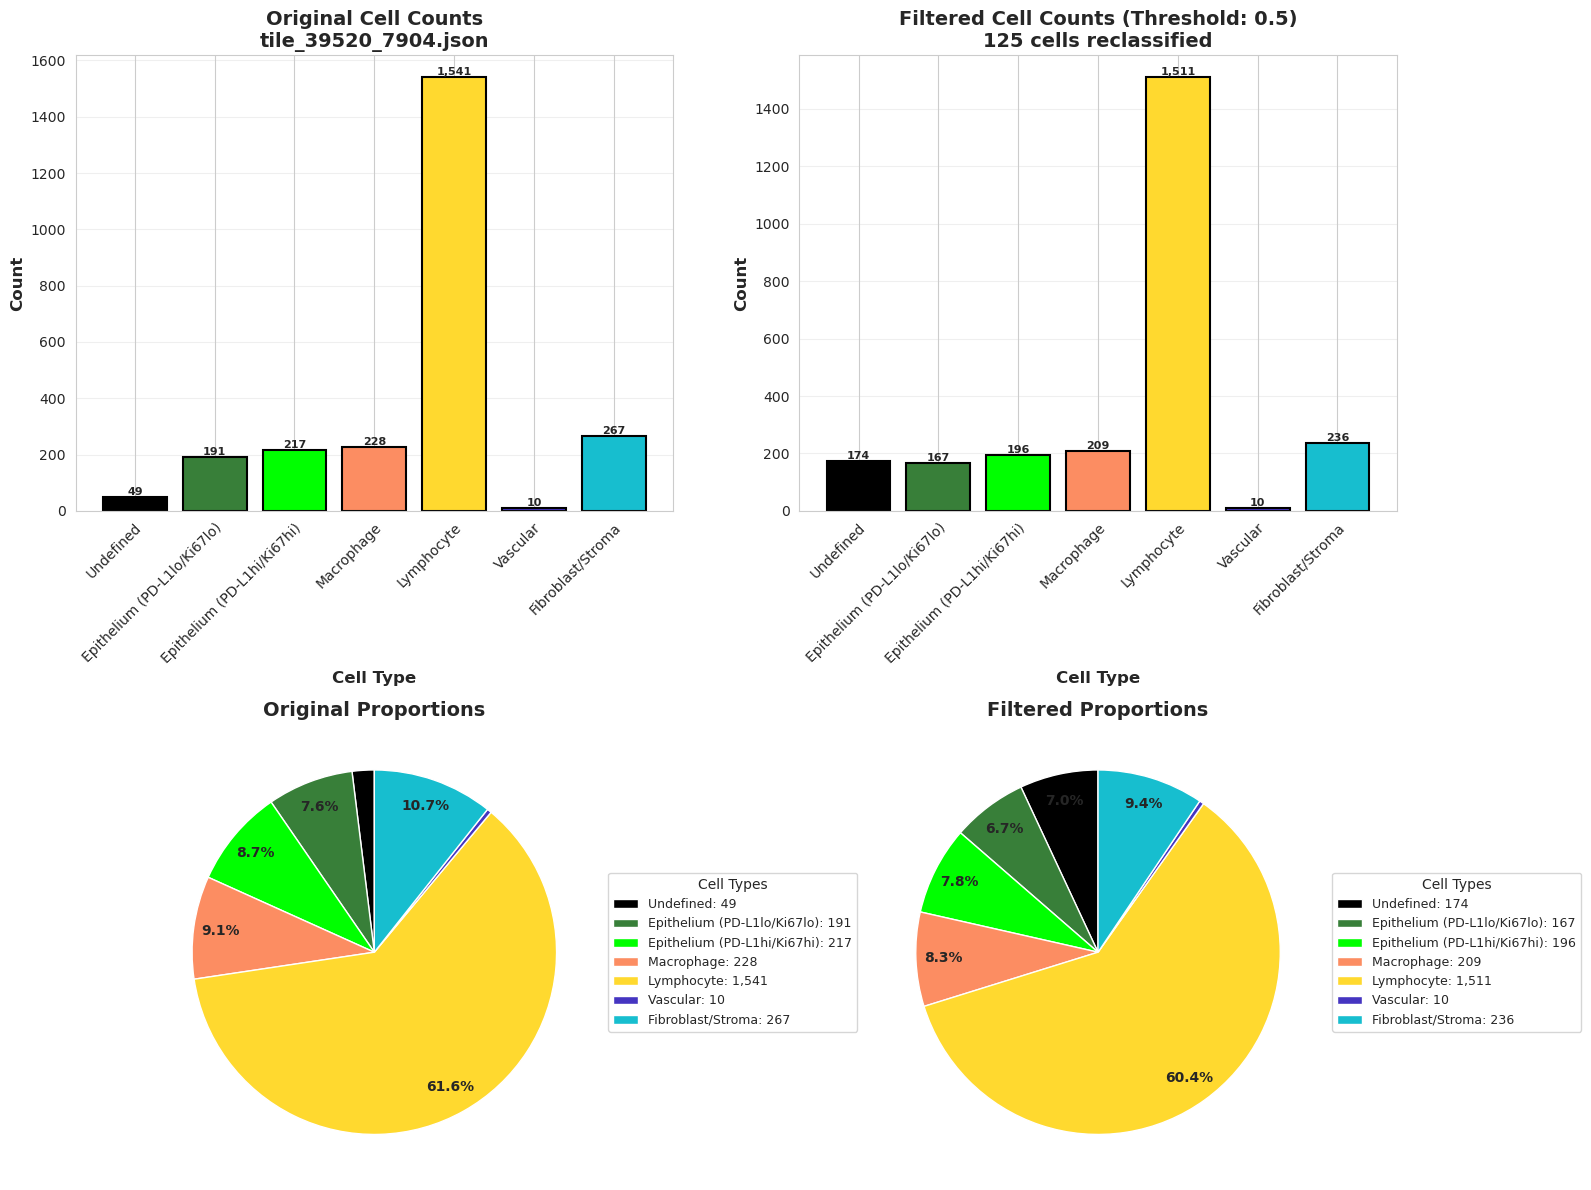

In [8]:
# ⚠️ Set your threshold here (default: 0.5)
CONFIDENCE_THRESHOLD = 0.5

if 'results' in locals():
    print(f"Applying confidence threshold filter: {CONFIDENCE_THRESHOLD}\n")

    # Apply filter
    filtered_results = apply_confidence_filter(json_file_path, threshold=CONFIDENCE_THRESHOLD)

    # Display filtered results
    display_filtered_results(filtered_results)

    # Create comparison visualizations
    print("\n📊 Generating comparison visualizations...\n")
    plot_filtered_comparison(results, filtered_results)

else:
    print("⚠️ No results to filter. Please run Step 6 first.")

## Step 8: Export Results to CSV/Excel

In [9]:
"""
## Step 8: Export Results to CSV/Excel

Export both original (unfiltered) and filtered results to separate CSV files.
"""

def export_results_to_csv(results, output_path="cell_analysis_results.csv", is_filtered=False):
    """
    Export analysis results to CSV file.

    Parameters:
    -----------
    results : dict
        Results dictionary from analyze_single_json() or apply_confidence_filter()
    output_path : str
        Path for output CSV file
    is_filtered : bool
        Whether these are filtered results (adds threshold info)
    """
    # Prepare data for DataFrame
    data_rows = []

    for cell_type in sorted(results['cell_counts'].keys()):
        type_name = CELL_TYPE_DICT.get(cell_type, f"Type {cell_type}")
        count = results['cell_counts'][cell_type]
        proportion = results['cell_proportions'][cell_type]

        stats = results['type_prob_stats_by_type'][cell_type]

        row_data = {
            'Filename': results['filename'],
            'Cell_Type_ID': cell_type,
            'Cell_Type_Name': type_name,
            'Count': count,
            'Proportion': proportion,
            'Percentage': proportion * 100,
            'TypeProb_Min': stats['min'],
            'TypeProb_Median': stats['median'],
            'TypeProb_Mean': stats['mean'],
            'TypeProb_Max': stats['max'],
            'TypeProb_Std': stats['std']
        }

        # Add filtered-specific columns
        if is_filtered:
            row_data['Original_Count'] = results['original_cell_counts'].get(cell_type, 0)
            row_data['Count_Change'] = count - results['original_cell_counts'].get(cell_type, 0)
            row_data['Threshold'] = results.get('threshold', 'N/A')

        data_rows.append(row_data)

    # Create DataFrame
    df = pd.DataFrame(data_rows)

    # Reorder columns for filtered results (Threshold at the end)
    if is_filtered:
        column_order = ['Filename', 'Cell_Type_ID', 'Cell_Type_Name',
                       'Original_Count', 'Count', 'Count_Change', 'Proportion', 'Percentage',
                       'TypeProb_Min', 'TypeProb_Median', 'TypeProb_Mean', 'TypeProb_Max',
                       'TypeProb_Std', 'Threshold']
        df = df[column_order]

    # Export to CSV
    df.to_csv(output_path, index=False)
    print(f"✅ Results exported to: {output_path}")

    return df

# Export both unfiltered and filtered results
print("="*80)
print("Exporting Results to CSV")
print("="*80)

if 'results' in locals() and 'filtered_results' in locals():
    # Export original (unfiltered) results
    print("\n📁 Exporting unfiltered results...")
    df_original = export_results_to_csv(
        results,
        output_path="cell_analysis_unfiltered.csv",
        is_filtered=False
    )

    # Export filtered results with threshold in filename
    threshold_value = filtered_results.get('threshold', 0.5)
    threshold_str = str(int(threshold_value * 100))  # Convert 0.5 to "50"
    filtered_output_path = f"cell_analysis_filtered_{threshold_str}.csv"

    print("\n📁 Exporting filtered results...")
    df_filtered = export_results_to_csv(
        filtered_results,
        output_path=filtered_output_path,
        is_filtered=True
    )

    # Display both DataFrames
    print("\n" + "─"*80)
    print("Unfiltered Results Preview:")
    print("─"*80)
    display(df_original)

    print("\n" + "─"*80)
    print(f"Filtered Results Preview (Threshold: {threshold_value}):")
    print("─"*80)
    display(df_filtered)

    # Summary
    print("\n" + "="*80)
    print("Export Summary:")
    print("="*80)
    print(f"✅ Unfiltered results: cell_analysis_unfiltered.csv ({len(df_original)} rows)")
    print(f"✅ Filtered results:   {filtered_output_path} ({len(df_filtered)} rows)")
    print(f"📊 Total cells reclassified: {filtered_results.get('reclassified_count', 0):,}")

elif 'results' in locals():
    # Only unfiltered results available
    print("\n⚠️ Filtered results not available. Only exporting unfiltered results.")
    df_original = export_results_to_csv(
        results,
        output_path="cell_analysis_unfiltered.csv",
        is_filtered=False
    )
    display(df_original)
    print("\n💡 Run Step 7 to generate filtered results before exporting.")

else:
    print("⚠️ No results to export. Please run Step 6 (and optionally Step 7) first.")

Exporting Results to CSV

📁 Exporting unfiltered results...
✅ Results exported to: cell_analysis_unfiltered.csv

📁 Exporting filtered results...
✅ Results exported to: cell_analysis_filtered_50.csv

────────────────────────────────────────────────────────────────────────────────
Unfiltered Results Preview:
────────────────────────────────────────────────────────────────────────────────


,Filename,Cell_Type_ID,Cell_Type_Name,Count,Proportion,Percentage,TypeProb_Min,TypeProb_Median,TypeProb_Mean,TypeProb_Max,TypeProb_Std
0,tile_39520_7904.json,0,Undefined,49,0.019577,1.957651,1.000000,1.000000,1.000000,1.00000,6.270541e-09
1,tile_39520_7904.json,1,Epithelium (PD-L1lo/Ki67lo),191,0.076308,7.630843,0.013605,0.873684,0.781446,1.00000,2.224995e-01
2,tile_39520_7904.json,2,Epithelium (PD-L1hi/Ki67hi),217,0.086696,8.669596,0.035714,0.873272,0.790516,1.00000,2.191618e-01
3,tile_39520_7904.json,3,Macrophage,228,0.091091,9.109069,0.010204,0.909625,0.811077,1.00000,2.168358e-01
4,tile_39520_7904.json,4,Lymphocyte,1541,0.615661,61.566121,0.058824,0.992883,0.941281,1.00000,1.274014e-01
5,tile_39520_7904.json,5,Vascular,10,0.003995,0.399521,0.513126,0.787088,0.770378,0.99435,1.910125e-01
6,tile_39520_7904.json,6,Fibroblast/Stroma,267,0.106672,10.667199,0.007722,0.889952,0.799950,1.00000,2.133720e-01



────────────────────────────────────────────────────────────────────────────────
Filtered Results Preview (Threshold: 0.5):
────────────────────────────────────────────────────────────────────────────────


,Filename,Cell_Type_ID,Cell_Type_Name,Original_Count,Count,Count_Change,Proportion,Percentage,TypeProb_Min,TypeProb_Median,TypeProb_Mean,TypeProb_Max,TypeProb_Std,Threshold
0,tile_39520_7904.json,0,Undefined,49,174,125,0.069517,6.951658,0.007722,0.450715,0.525022,1.00000,0.323875,0.5
1,tile_39520_7904.json,1,Epithelium (PD-L1lo/Ki67lo),191,167,-24,0.066720,6.671994,0.504273,0.894915,0.843649,1.00000,0.150737,0.5
2,tile_39520_7904.json,2,Epithelium (PD-L1hi/Ki67hi),217,196,-21,0.078306,7.830603,0.504178,0.903120,0.843094,1.00000,0.147420,0.5
3,tile_39520_7904.json,3,Macrophage,228,209,-19,0.083500,8.349980,0.501567,0.927807,0.856927,1.00000,0.151880,0.5
4,tile_39520_7904.json,4,Lymphocyte,1541,1511,-30,0.603676,60.367559,0.503759,0.993080,0.952439,1.00000,0.099416,0.5
5,tile_39520_7904.json,5,Vascular,10,10,0,0.003995,0.399521,0.513126,0.787088,0.770378,0.99435,0.191012,0.5
6,tile_39520_7904.json,6,Fibroblast/Stroma,267,236,-31,0.094287,9.428686,0.513089,0.911459,0.860600,1.00000,0.130880,0.5



Export Summary:
✅ Unfiltered results: cell_analysis_unfiltered.csv (7 rows)
✅ Filtered results:   cell_analysis_filtered_50.csv (7 rows)
📊 Total cells reclassified: 125


## Step 9: Batch Analysis (All JSON Files)

Process all JSON files in a directory and aggregate results.

BATCH ANALYSIS - Processing All JSON Files

📊 Step 1: Analyzing unfiltered results...
Found 122 JSON files (unfiltered)
Processing...

Processed 10/122 files...
Processed 20/122 files...
Processed 30/122 files...
Processed 40/122 files...
Processed 50/122 files...
Processed 60/122 files...
Processed 70/122 files...
Processed 80/122 files...
Processed 90/122 files...
Processed 100/122 files...
Processed 110/122 files...
Processed 120/122 files...

✅ Completed! Processed 122 files.

AGGREGATED RESULTS - UNFILTERED
Total Files: 122
Total Cells: 114,336

────────────────────────────────────────────────────────────────────────────────
Cell Type                                  Count   Proportion   Percentage
────────────────────────────────────────────────────────────────────────────────
Undefined                                  5,371       0.0470        4.70%
Epithelium (PD-L1lo/Ki67lo)                8,877       0.0776        7.76%
Epithelium (PD-L1hi/Ki67hi)               30,464       0

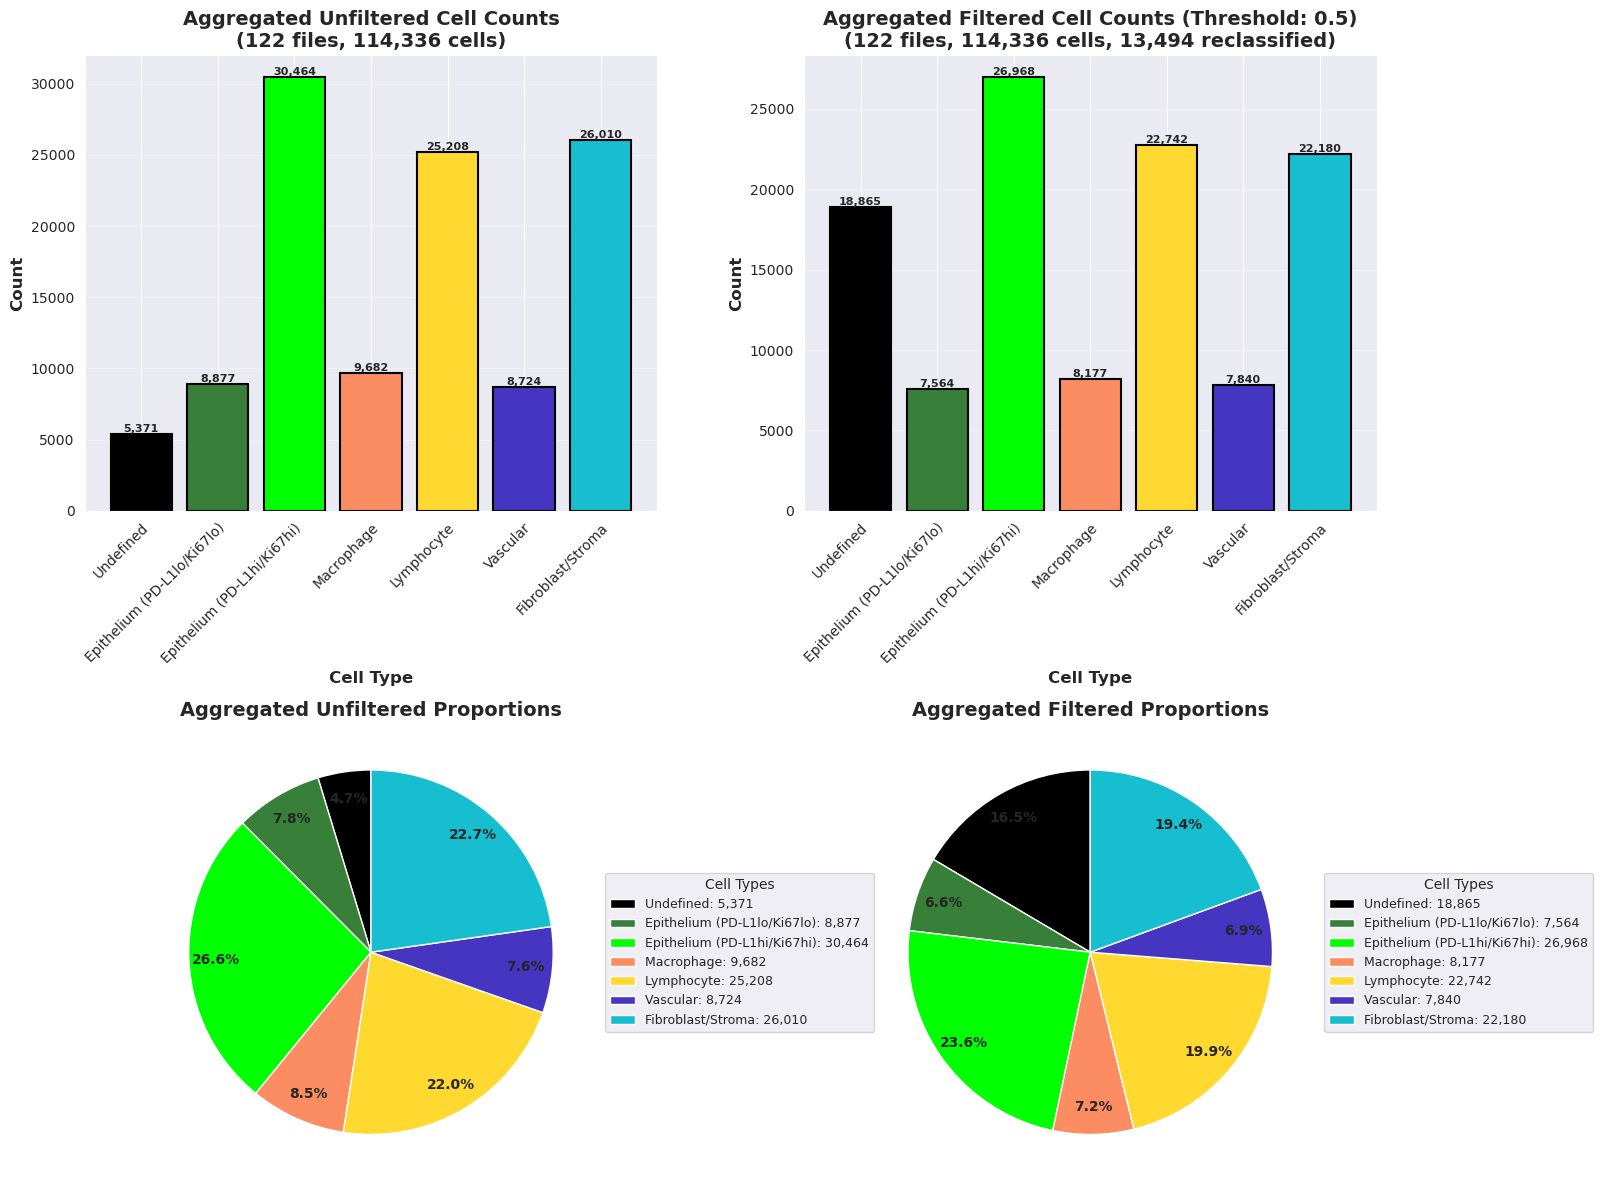


📊 Step 4: Exporting aggregated results to CSV...
✅ Aggregated results exported to: aggregated_results_unfiltered.csv
✅ Aggregated results exported to: aggregated_results_filtered_50.csv

BATCH ANALYSIS COMPLETE
✅ Processed 122 JSON files
✅ Total cells analyzed: 114,336
✅ Cells reclassified with threshold 0.5: 13,494

📁 Output files:
   - aggregated_results_unfiltered.csv
   - aggregated_results_filtered_50.csv

✅ Batch analysis complete!


In [10]:
"""
## Step 9: Batch Analysis (All JSON Files) - REFACTORED

Process all JSON files in a directory and aggregate results for both unfiltered and filtered data.
"""

# Configuration constants
PIE_CHART_MIN_PERCENT = 3.0
FIGURE_SIZE = (16, 12)
PROGRESS_INTERVAL = 10


def analyze_multiple_json_files(json_directory, apply_filter=False, threshold=0.5):
    """
    Analyze all JSON files in a directory.

    Parameters:
    -----------
    json_directory : str or Path
        Path to directory containing JSON files
    apply_filter : bool
        Whether to apply confidence threshold filter
    threshold : float
        Confidence threshold (only used if apply_filter=True)

    Returns:
    --------
    list : List of result dictionaries
    """
    json_dir = Path(json_directory)
    json_files = sorted(json_dir.glob("*.json"))

    if not json_files:
        print(f"❌ No JSON files found in {json_directory}")
        return []

    filter_status = f" (with filter threshold={threshold})" if apply_filter else " (unfiltered)"
    print(f"Found {len(json_files)} JSON files{filter_status}")
    print("Processing...\n")

    all_results = []
    process_func = (lambda f: apply_confidence_filter(f, threshold=threshold)) if apply_filter else analyze_single_json

    for i, json_file in enumerate(json_files, 1):
        if i % PROGRESS_INTERVAL == 0:
            print(f"Processed {i}/{len(json_files)} files...")
        all_results.append(process_func(json_file))

    print(f"\n✅ Completed! Processed {len(json_files)} files.")
    return all_results


def aggregate_results(all_results, is_filtered=False):
    """
    Aggregate results from multiple JSON files.

    Parameters:
    -----------
    all_results : list
        List of result dictionaries
    is_filtered : bool
        Whether these are filtered results

    Returns:
    --------
    dict : Aggregated statistics
    """
    total_cells_all = sum(r['total_cells'] for r in all_results)

    # Aggregate counts by cell type
    aggregated_counts = Counter()
    for result in all_results:
        aggregated_counts.update(result['cell_counts'])

    # Calculate overall proportions
    aggregated_proportions = {
        cell_type: count / total_cells_all
        for cell_type, count in aggregated_counts.items()
    }

    aggregated = {
        'total_files': len(all_results),
        'total_cells': total_cells_all,
        'aggregated_counts': dict(aggregated_counts),
        'aggregated_proportions': aggregated_proportions
    }

    # Add filtered-specific information
    if is_filtered:
        original_counts = Counter()
        for result in all_results:
            original_counts.update(result.get('original_cell_counts', {}))

        aggregated.update({
            'total_reclassified': sum(r.get('reclassified_count', 0) for r in all_results),
            'aggregated_original_counts': dict(original_counts),
            'threshold': all_results[0].get('threshold', 'N/A') if all_results else 'N/A'
        })

    return aggregated


def display_aggregated_results(aggregated, is_filtered=False):
    """
    Display aggregated results.

    Parameters:
    -----------
    aggregated : dict
        Aggregated results dictionary
    is_filtered : bool
        Whether these are filtered results
    """
    # Header
    title = "AGGREGATED RESULTS - FILTERED" if is_filtered else "AGGREGATED RESULTS - UNFILTERED"
    print(f"\n{'='*80}\n{title}")
    if is_filtered:
        print(f"Threshold: {aggregated.get('threshold', 'N/A')}")
    print(f"{'='*80}\nTotal Files: {aggregated['total_files']}\nTotal Cells: {aggregated['total_cells']:,}")

    if is_filtered:
        reclassified = aggregated.get('total_reclassified', 0)
        pct = reclassified / aggregated['total_cells'] * 100
        print(f"Total Reclassified: {reclassified:,} ({pct:.2f}%)")

    # Table header
    print(f"\n{'─'*80}")
    if is_filtered:
        print(f"{'Cell Type':<35} {'Original':>12} {'Filtered':>12} {'Change':>12} {'Proportion':>12}")
    else:
        print(f"{'Cell Type':<35} {'Count':>12} {'Proportion':>12} {'Percentage':>12}")
    print('─'*80)

    # Table rows
    for cell_type in sorted(aggregated['aggregated_counts'].keys()):
        type_name = CELL_TYPE_DICT[cell_type]
        count = aggregated['aggregated_counts'][cell_type]
        proportion = aggregated['aggregated_proportions'][cell_type]
        percentage = proportion * 100

        if is_filtered:
            original_count = aggregated.get('aggregated_original_counts', {}).get(cell_type, 0)
            change = count - original_count
            change_str = f"+{change:,}" if change >= 0 else f"{change:,}"
            print(f"{type_name:<35} {original_count:>12,} {count:>12,} {change_str:>12} {percentage:>11.2f}%")
        else:
            print(f"{type_name:<35} {count:>12,} {proportion:>12.4f} {percentage:>11.2f}%")

    print('='*80)


def _create_bar_chart(ax, cell_types, cell_names, colors, counts, title):
    """Helper function to create a bar chart."""
    ax.bar(range(len(cell_types)), counts, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Cell Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xticks(range(len(cell_types)))
    ax.set_xticklabels(cell_names, rotation=45, ha='right', rotation_mode='anchor')
    ax.grid(axis='y', alpha=0.3)
    for i, count in enumerate(counts):
        ax.text(i, count, f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=8)


def _create_pie_chart(ax, cell_names, colors, counts, title):
    """Helper function to create a pie chart."""
    def autopct_format(pct):
        return f'{pct:.1f}%' if pct > PIE_CHART_MIN_PERCENT else ''

    wedges, _, _ = ax.pie(
        counts,
        labels=None,
        colors=colors,
        autopct=autopct_format,
        startangle=90,
        textprops={'fontsize': 10, 'weight': 'bold'},
        pctdistance=0.85
    )
    legend_labels = [f'{name}: {count:,}' for name, count in zip(cell_names, counts)]
    ax.legend(wedges, legend_labels, title="Cell Types", loc="center left",
              bbox_to_anchor=(1, 0, 0.5, 1), fontsize=9)
    ax.set_title(title, fontsize=14, fontweight='bold')


def plot_aggregated_comparison(aggregated_unfiltered, aggregated_filtered):
    """
    Create comparison visualization of aggregated unfiltered vs filtered results.

    Parameters:
    -----------
    aggregated_unfiltered : dict
        Aggregated unfiltered results
    aggregated_filtered : dict
        Aggregated filtered results
    """
    fig, axes = plt.subplots(2, 2, figsize=FIGURE_SIZE)

    # Get all cell types and prepare data
    all_cell_types = set(aggregated_unfiltered['aggregated_counts'].keys()) | \
                     set(aggregated_filtered['aggregated_counts'].keys())
    cell_types = sorted(all_cell_types)
    cell_names = [CELL_TYPE_DICT.get(ct, f"Type {ct}") for ct in cell_types]
    colors = [CELL_TYPE_COLORS.get(ct, "#808080") for ct in cell_types]

    unfiltered_counts = [aggregated_unfiltered['aggregated_counts'].get(ct, 0) for ct in cell_types]
    filtered_counts = [aggregated_filtered['aggregated_counts'].get(ct, 0) for ct in cell_types]

    # Create charts using helper functions
    _create_bar_chart(
        axes[0, 0], cell_types, cell_names, colors, unfiltered_counts,
        f'Aggregated Unfiltered Cell Counts\n({aggregated_unfiltered["total_files"]} files, '
        f'{aggregated_unfiltered["total_cells"]:,} cells)'
    )

    _create_bar_chart(
        axes[0, 1], cell_types, cell_names, colors, filtered_counts,
        f'Aggregated Filtered Cell Counts (Threshold: {aggregated_filtered.get("threshold", "N/A")})\n'
        f'({aggregated_filtered["total_files"]} files, {aggregated_filtered["total_cells"]:,} cells, '
        f'{aggregated_filtered.get("total_reclassified", 0):,} reclassified)'
    )

    _create_pie_chart(
        axes[1, 0], cell_names, colors, unfiltered_counts,
        'Aggregated Unfiltered Proportions'
    )

    _create_pie_chart(
        axes[1, 1], cell_names, colors, filtered_counts,
        'Aggregated Filtered Proportions'
    )

    plt.tight_layout()
    plt.show()


def export_aggregated_results(aggregated, output_path, is_filtered=False):
    """
    Export aggregated results to CSV.

    Parameters:
    -----------
    aggregated : dict
        Aggregated results dictionary
    output_path : str
        Output file path
    is_filtered : bool
        Whether these are filtered results
    """
    data_rows = []

    for cell_type in sorted(aggregated['aggregated_counts'].keys()):
        count = aggregated['aggregated_counts'][cell_type]
        proportion = aggregated['aggregated_proportions'][cell_type]

        row_data = {
            'Total_Files': aggregated['total_files'],
            'Total_Cells': aggregated['total_cells'],
            'Cell_Type_ID': cell_type,
            'Cell_Type_Name': CELL_TYPE_DICT.get(cell_type, f"Type {cell_type}"),
            'Count': count,
            'Proportion': proportion,
            'Percentage': proportion * 100
        }

        if is_filtered:
            original_count = aggregated.get('aggregated_original_counts', {}).get(cell_type, 0)
            row_data.update({
                'Original_Count': original_count,
                'Count_Change': count - original_count,
                'Total_Reclassified': aggregated.get('total_reclassified', 0),
                'Threshold': aggregated.get('threshold', 'N/A')
            })

        data_rows.append(row_data)

    df = pd.DataFrame(data_rows)

    # Reorder columns for filtered results
    if is_filtered:
        column_order = ['Total_Files', 'Total_Cells', 'Total_Reclassified', 'Cell_Type_ID', 'Cell_Type_Name',
                       'Original_Count', 'Count', 'Count_Change', 'Proportion', 'Percentage', 'Threshold']
        df = df[column_order]

    df.to_csv(output_path, index=False)
    print(f"✅ Aggregated results exported to: {output_path}")
    return df


def run_batch_analysis(json_directory, threshold=0.5):
    """
    Run complete batch analysis pipeline.

    Parameters:
    -----------
    json_directory : str or Path
        Path to directory containing JSON files
    threshold : float
        Confidence threshold for filtered analysis
    """
    print("="*80)
    print("BATCH ANALYSIS - Processing All JSON Files")
    print("="*80)

    # Process unfiltered results
    print("\n📊 Step 1: Analyzing unfiltered results...")
    all_results_unfiltered = analyze_multiple_json_files(json_directory, apply_filter=False)
    aggregated_unfiltered = aggregate_results(all_results_unfiltered, is_filtered=False)
    display_aggregated_results(aggregated_unfiltered, is_filtered=False)

    # Process filtered results
    print(f"\n📊 Step 2: Analyzing filtered results (threshold={threshold})...")
    all_results_filtered = analyze_multiple_json_files(json_directory, apply_filter=True, threshold=threshold)
    aggregated_filtered = aggregate_results(all_results_filtered, is_filtered=True)
    display_aggregated_results(aggregated_filtered, is_filtered=True)

    # Visualize comparison
    print("\n📊 Step 3: Generating comparison visualizations...")
    plot_aggregated_comparison(aggregated_unfiltered, aggregated_filtered)

    # Export results
    print("\n📊 Step 4: Exporting aggregated results to CSV...")
    df_agg_unfiltered = export_aggregated_results(
        aggregated_unfiltered,
        "aggregated_results_unfiltered.csv",
        is_filtered=False
    )

    threshold_str = str(int(threshold * 100))
    df_agg_filtered = export_aggregated_results(
        aggregated_filtered,
        f"aggregated_results_filtered_{threshold_str}.csv",
        is_filtered=True
    )

    # Summary
    print("\n" + "="*80)
    print("BATCH ANALYSIS COMPLETE")
    print("="*80)
    print(f"✅ Processed {aggregated_unfiltered['total_files']} JSON files")
    print(f"✅ Total cells analyzed: {aggregated_unfiltered['total_cells']:,}")
    print(f"✅ Cells reclassified with threshold {threshold}: {aggregated_filtered.get('total_reclassified', 0):,}")
    print("\n📁 Output files:")
    print("   - aggregated_results_unfiltered.csv")
    print(f"   - aggregated_results_filtered_{threshold_str}.csv")
    print("\n✅ Batch analysis complete!")

    return aggregated_unfiltered, aggregated_filtered


# ⚠️ UPDATE THIS PATH TO YOUR JSON DIRECTORY
json_directory = "/mnt/g/GDC-TCGA-LUAD/00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/pred_00a0b174-1eab-446a-ba8c-7c6e3acd7f0c/json"
BATCH_THRESHOLD = 0.5

# Run the complete analysis
aggregated_unfiltered, aggregated_filtered = run_batch_analysis(json_directory, BATCH_THRESHOLD)

## Summary

This notebook provides:
1. ✅ Single JSON file analysis
2. ✅ Cell type counts and proportions
3. ✅ Type probability statistics (min, median, mean, max)
4. ✅ Visualizations (bar charts, pie charts)
5. ✅ CSV export functionality
6. ✅ Batch processing for all JSON files

**Next Steps:**
- Use these counts for spatial analysis
- Compare distributions across different tissue regions
- Correlate with clinical outcomes

---